# KAN vs MLP for Time Series Forecasting

## 1. Import Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from synthetic import simulate_var
from torch.utils.data import DataLoader, TensorDataset
from models.kan import KAN
from models.model_helper import activation_helper
from tqdm import tqdm

# torch.set_default_dtype(torch.float64)

## 2. Hyperparameters

In [2]:
lag = 5  # number of lags
T = 1000  # number of time points
num_series = 10  # number of time series

batch_size = 32
epochs = 100
lr = 1e-3

dim_input = num_series * lag
dim_output = 1

## 3. Generate Data

In [3]:
# Simulate data with causal relationships
X_np, beta, GC = simulate_var(p=num_series, T=T, lag=lag, sparsity=0.6)
X = torch.tensor(X_np[np.newaxis], dtype=torch.float32)  # add one new dimension for X

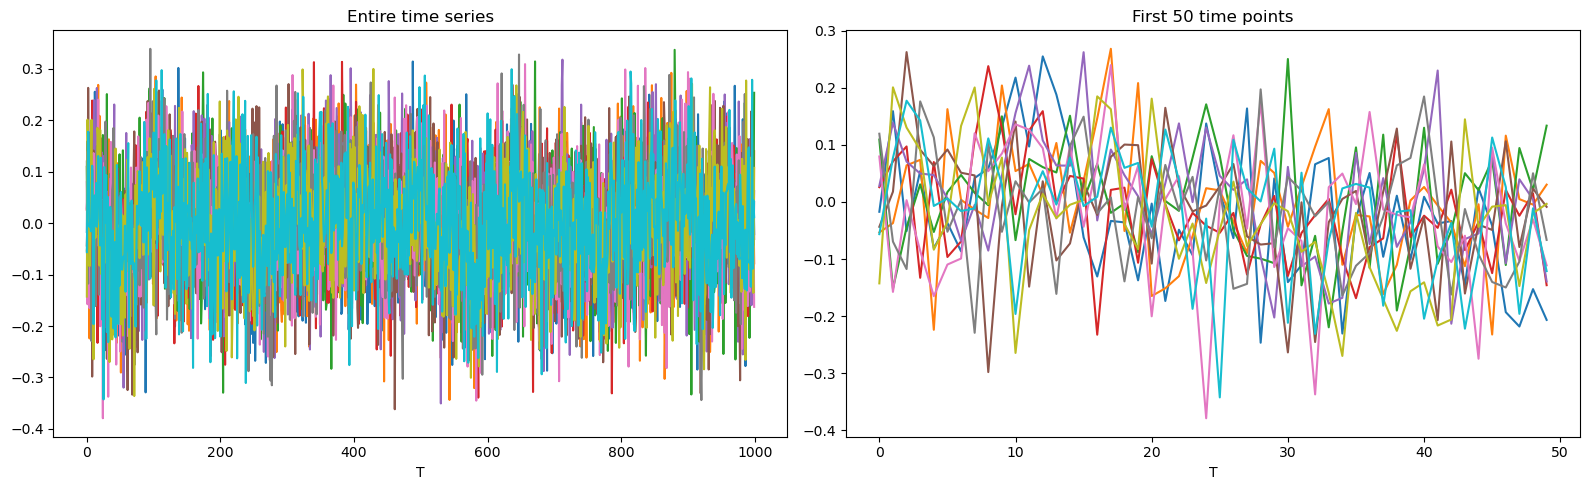

In [4]:
# Plot data
fig, axarr = plt.subplots(1, 2, figsize=(16, 5))
axarr[0].plot(X_np)
axarr[0].set_xlabel('T')
axarr[0].set_title('Entire time series')
axarr[1].plot(X_np[:50])
axarr[1].set_xlabel('T')
axarr[1].set_title('First 50 time points')
plt.tight_layout()
plt.show()

Plot the granger causality among time series

[[1 0 1 1 0 1 0 0 1 1]
 [0 1 1 0 1 0 0 1 1 1]
 [0 1 1 1 1 1 1 0 0 0]
 [1 0 1 1 0 0 1 1 1 0]
 [0 1 0 0 1 1 1 1 1 0]
 [0 0 1 0 1 1 1 0 1 1]
 [1 1 1 0 0 1 1 0 0 1]
 [0 1 1 1 0 0 1 1 1 0]
 [1 0 0 1 0 1 0 1 1 1]
 [1 1 0 0 1 1 0 1 0 1]]


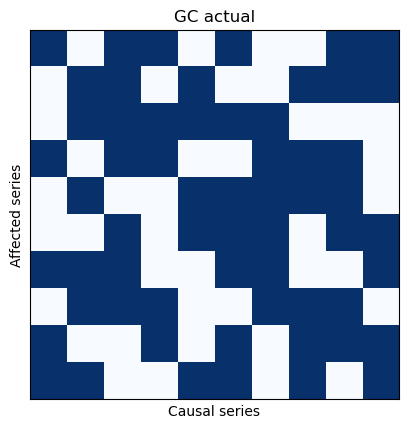

In [5]:
print(GC)

plt.imshow(GC, cmap='Blues')
plt.title('GC actual')
plt.ylabel('Affected series')
plt.xlabel('Causal series')
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.show()

## 4. Prepare the Data

- In this section, we choose TS1 as the target time series.

- The lags of the rest 4 series and TS1 itself will be used to predict the current value of TS1.

- For TS1, it is affected by TS0, TS1, TS3.

In [6]:
target_series = 1  # the series we want to predict

In [7]:
def pd_data(X):
    '''
    Use dataframe to show the data structure
    Y: target series
    ts{}_lag{}: value of time series {} with lag {}
    '''
    Y = X[:, :, target_series]
    df = pd.DataFrame({'Y': Y[0,:].detach().numpy()})[lag:]
    for i in range(num_series):
        for j in range(lag):
            df['ts{}_lag{}'.format(i, lag-j)] = X[0, :, i].detach().numpy()[j:-lag+j]
    return df

def rearrange_data(X):
    '''
    Rearrange the time series, to form a data with lags

    Input:
        X: tensor with shape (1, num_series, T)
    Output:
        array: tensor with shape (num_series * lag, T-lag)
    '''
    li = []
    for i in range(num_series):
        for j in range(lag):
            li.append(X[0, :, i].detach().numpy()[j:-lag+j])

    # transfer li to tensor
    array = torch.tensor(li, dtype=torch.float32)

    return array

In [8]:
array = rearrange_data(X).T
print(array.shape)

Y = X[:, :, target_series][0, :T-lag].reshape(1, T-lag).T
print(Y.shape)

# Show the data structure using dataframe
# pd_data(X)

# put the data into DataLoader
trainloader = DataLoader(TensorDataset(array, Y), batch_size=32, shuffle=True)

torch.Size([995, 50])
torch.Size([995, 1])


/var/folders/yl/m5cgc23j1gbfcvxxglrgsk0w0000gn/T/ipykernel_79543/389140576.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d63z49rj_/croot/pytorch_1681837279022/work/torch/csrc/utils/tensor_new.cpp:233.)
  array = torch.tensor(li, dtype=torch.float32)


## 5. Predict using KAN

### 5.1 Explore how the layer width can affect the result. (Depth=1)

In [9]:
layers = [4, 8, 16]
kan_loss_width_all = []
kan_output_width_all = []

for layer in layers:
    model = KAN([dim_input, layer, dim_output])
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    kan_loss = []
    print("-" * 10)
    print("Hidden layer number: ", layer)

    for epoch in range(epochs):
        # Train
        model.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        kan_loss.append(loss.item())
        if (epoch+1) % 10 == 0:
            print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    kan_output_width_all.append(model(array).detach().numpy())
    kan_loss_width_all.append(kan_loss)

----------
Hidden layer number:  4
Epoch: 10, loss: 7.060659845592454e-05
Epoch: 20, loss: 2.780653858280857e-06
Epoch: 30, loss: 1.1807758710347116e-05
Epoch: 40, loss: 9.92823697743006e-06
Epoch: 50, loss: 4.22392986365594e-06
Epoch: 60, loss: 8.40297889226349e-06
Epoch: 70, loss: 5.154608061275212e-06
Epoch: 80, loss: 4.431695742823649e-06
Epoch: 90, loss: 3.8907731436665927e-07
Epoch: 100, loss: 7.018271048764291e-07
----------
Hidden layer number:  8
Epoch: 10, loss: 5.110635538585484e-05
Epoch: 20, loss: 8.997202712635044e-06
Epoch: 30, loss: 1.7841601902546245e-06
Epoch: 40, loss: 2.898350203395239e-06
Epoch: 50, loss: 5.91544312555925e-06
Epoch: 60, loss: 6.111241873441031e-06
Epoch: 70, loss: 3.527185015173018e-07
Epoch: 80, loss: 2.029193638009019e-06
Epoch: 90, loss: 2.4227947506005876e-06
Epoch: 100, loss: 5.9604463586993006e-08
----------
Hidden layer number:  16
Epoch: 10, loss: 2.5423166789551033e-06
Epoch: 20, loss: 8.751952009333763e-06
Epoch: 30, loss: 7.6809683378087

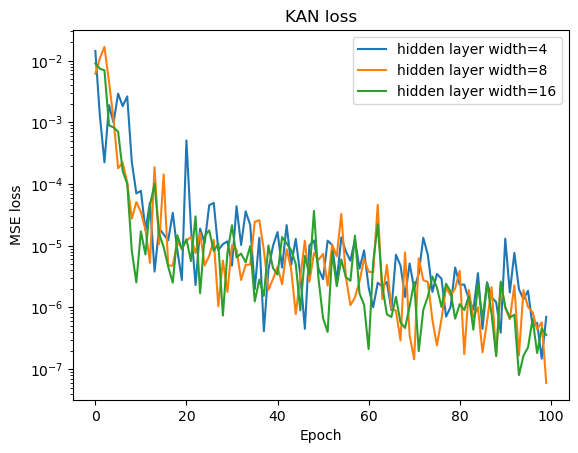

In [10]:
for i, kan_loss in enumerate(kan_loss_width_all):
    plt.plot(kan_loss, label='hidden layer width={}'.format(layers[i]))
    # log scale 
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.title('KAN loss')
plt.show()

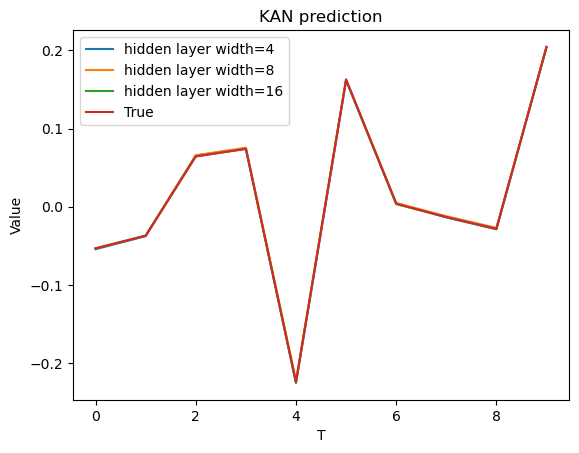

In [11]:
for i, kan_output in enumerate(kan_output_width_all):
    plt.plot(kan_output[:10], label='hidden layer width={}'.format(layers[i]))
plt.plot(Y[:10], label='True')
plt.legend()
plt.xlabel('T')
plt.ylabel('Value')
plt.title('KAN prediction')
plt.show()

### 5.2 Explore how layer depth can affect the result. (Width=4)

In [12]:
layers = [
    [dim_input, 4, dim_output],
    [dim_input, 4, 4, dim_output],
    [dim_input, 4, 4, 4, dim_output]
]
kan_loss_depth_all = []
kan_output_depth_all = []

for i, layer in enumerate(layers):
    model = KAN(layer)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    kan_loss = []
    print("-" * 10)
    print("Hidden layer depth: ", i+1)

    for epoch in range(epochs):
        # Train
        model.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        kan_loss.append(loss.item())
        if (epoch+1) % 10 == 0:
            print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    kan_output_depth_all.append(model(array).detach().numpy())
    kan_loss_depth_all.append(kan_loss)

----------
Hidden layer depth:  1
Epoch: 10, loss: 5.978571061859839e-05
Epoch: 20, loss: 1.0151082278753165e-05
Epoch: 30, loss: 5.4583738346991595e-06
Epoch: 40, loss: 3.169872798025608e-06
Epoch: 50, loss: 1.4356006658999831e-06
Epoch: 60, loss: 9.122076249923339e-08
Epoch: 70, loss: 7.348936037487874e-07
Epoch: 80, loss: 1.4647950763446715e-07
Epoch: 90, loss: 1.368254771705324e-07
Epoch: 100, loss: 1.0414324833618593e-06
----------
Hidden layer depth:  2
Epoch: 10, loss: 2.3571987185277976e-05
Epoch: 20, loss: 3.3834348869277164e-05
Epoch: 30, loss: 1.4040884707355872e-05
Epoch: 40, loss: 4.275356332072988e-06
Epoch: 50, loss: 1.8695600374485366e-06
Epoch: 60, loss: 1.8866729760702583e-06
Epoch: 70, loss: 2.829634695444838e-07
Epoch: 80, loss: 6.109584660407563e-07
Epoch: 90, loss: 1.2141059357873019e-07
Epoch: 100, loss: 9.480766038905131e-08
----------
Hidden layer depth:  3
Epoch: 10, loss: 0.0001010312043945305
Epoch: 20, loss: 1.7209540601470508e-05
Epoch: 30, loss: 6.3675693

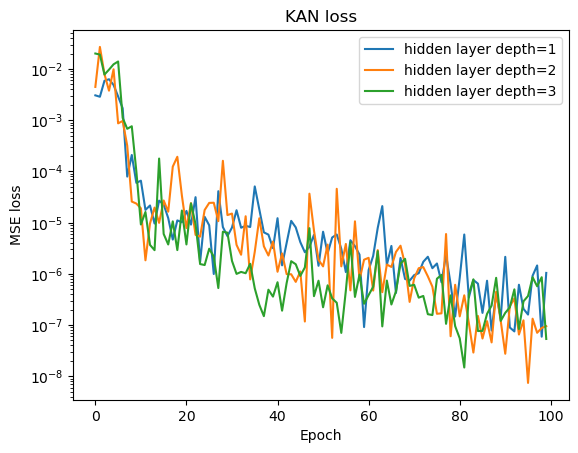

In [13]:
for i, kan_loss in enumerate(kan_loss_depth_all):
    plt.plot(kan_loss, label='hidden layer depth={}'.format(i+1))
    # log scale 
    plt.yscale('log')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('MSE loss')
    plt.title('KAN loss')
plt.show()

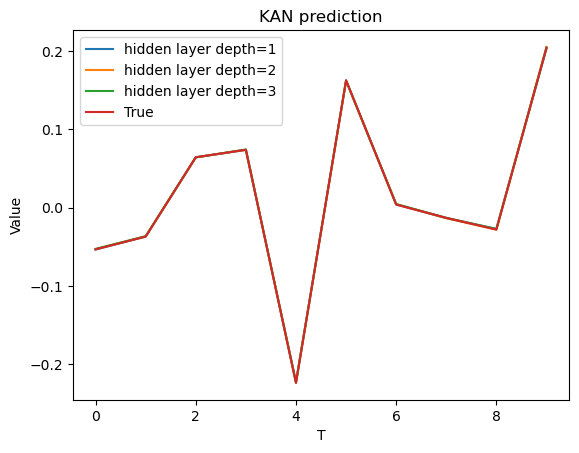

In [14]:
for i, kan_output in enumerate(kan_output_depth_all):
    plt.plot(kan_output[:10], label='hidden layer depth={}'.format(i+1))
plt.plot(Y[:10], label='True')
plt.legend()
plt.xlabel('T')
plt.ylabel('Value')
plt.title('KAN prediction')
plt.show()

## 6. Predict using MLP

In [15]:
class MLP(nn.Module):
    def __init__(self, layers):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            if i != len(layers) - 2:
                self.layers.append(activation_helper('relu'))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [16]:
layers = [4, 8, 16]
mlp_loss_all = []
mlp_output_all = []

for layer in layers:
    model = MLP([dim_input, layer, dim_output])
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    mlp_loss = []
    print("-" * 10)
    print("Hidden layer number: ", layer)

    for epoch in range(epochs):
        # Train
        model.train()
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
        mlp_loss.append(loss.item())
        if (epoch+1) % 5 == 0:
            print('Epoch: {}, loss: {}'.format(epoch + 1, loss.item()))
    
    mlp_output_all.append(model(array).detach().numpy())
    mlp_loss_all.append(mlp_loss)

----------
Hidden layer number:  4
Epoch: 5, loss: 0.0017014127224683762
Epoch: 10, loss: 0.0038587867747992277
Epoch: 15, loss: 3.53925752278883e-05
Epoch: 20, loss: 7.886101229814813e-07
Epoch: 25, loss: 5.267813321552239e-06
Epoch: 30, loss: 6.016770726091636e-07
Epoch: 35, loss: 2.89436229650164e-07
Epoch: 40, loss: 2.7439227778813802e-08
Epoch: 45, loss: 4.543585063743194e-08
Epoch: 50, loss: 3.021817107651259e-08
Epoch: 55, loss: 2.2662469234546734e-08
Epoch: 60, loss: 1.5259452368354687e-08
Epoch: 65, loss: 1.196446675066909e-08
Epoch: 70, loss: 1.886512102089455e-08
Epoch: 75, loss: 2.1754127388362576e-08
Epoch: 80, loss: 3.192350161995705e-09
Epoch: 85, loss: 7.213086572477323e-09
Epoch: 90, loss: 1.3405653254139338e-09
Epoch: 95, loss: 5.000437286462045e-10
Epoch: 100, loss: 3.491059885618597e-09
----------
Hidden layer number:  8
Epoch: 5, loss: 0.00723058357834816
Epoch: 10, loss: 0.004374668002128601
Epoch: 15, loss: 0.0016840471653267741
Epoch: 20, loss: 0.000528803037013

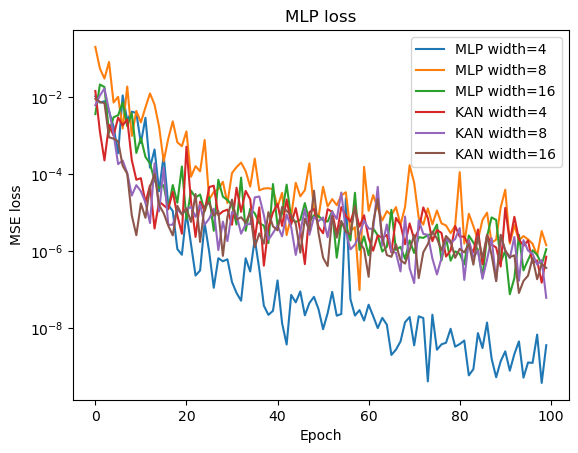

In [17]:
for i, mlp_loss in enumerate(mlp_loss_all):
    plt.plot(mlp_loss, label='MLP width={}'.format(layers[i]))
for i, kan_loss in enumerate(kan_loss_width_all):
    plt.plot(kan_loss, label='KAN width={}'.format(layers[i]))
# log scale 
plt.yscale('log')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('MLP loss')
plt.show()